In [ ]:
#Upload: check performance on test data
#Code quality doesn’t go into the grading that much, but can get feedback in a proper way (check Gist github, for notebooks)
#We can use whatever we want


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, mutual_info_classif, SelectKBest

## Load data

In [ ]:
data = pd.read_csv('train_data.csv')

In [ ]:
#Labels (quite imbalanced)
data['target'].value_counts()

2    1032
1     314
0     247
Name: target, dtype: int64

In [ ]:
#Bool variables to float

data["forecast_category_at_time_of_weekstart_1_Commit"] = data['forecast_category_at_time_of_weekstart_1_Commit'].astype(float)
data["forecast_category_at_time_of_weekstart_3_Best_Case"] = data["forecast_category_at_time_of_weekstart_3_Best_Case"].astype(float)
data["forecast_category_at_time_of_weekstart_4_Pipeline"] = data["forecast_category_at_time_of_weekstart_4_Pipeline"].astype(float)

In [ ]:
#Merging dates and id into one single identifier

data['opportunity_id'] = data['opportunity_id'].astype(str) + '_' + data['current_date_day'].astype(str) + '_' + data['current_date_month'].astype(str) +'_' + data['current_date_year'].astype(str)

data.drop(['current_date_day'], axis = 1, inplace = True)
data.drop(['current_date_month'], axis = 1, inplace = True)
data.drop(['current_date_year'], axis = 1, inplace = True)

In [ ]:
data

,opportunity_id,TOPICS__mean_calls_Integration__from_opp_creation,TOPICS__min_calls_Library__last_28_days,QUESTIONS__std_num_of_questions_in_calls_by_customer__last_7_days,TOPICS__min_calls_Collaboration__from_current_stage_start,TOPICS__std_calls_Integrations__last_7_days,TOPICS__min_calls_Evaluation_Process__from_current_stage_start,TOPICS__total_calls_3_Pillars__last_28_days,TOPICS__mean_non_zero_calls_Business_Overview__from_current_stage_start,TOPICS__total_calls_Wrap-Up__from_opp_creation,...,forecast_category_at_time_of_weekstart_1_Commit,forecast_category_at_time_of_weekstart_3_Best_Case,forecast_category_at_time_of_weekstart_4_Pipeline,fc_transition,opportunity_stage_at_time_of_weekstart_max,opportunity_stage_at_time_of_weekstart_min,stage_transition,current_quarter,timetoclose,target
0,15427464874523186_2_11_2021,NaN,NaN,0.000000,NaN,NaN,NaN,7325.6640,NaN,NaN,...,1.0,0.0,0.0,0.0,23.0,23.0,0.0,4,28,2
1,15427464874523186_9_11_2021,NaN,NaN,0.000000,NaN,NaN,NaN,7325.6640,NaN,NaN,...,1.0,0.0,0.0,0.0,40.0,40.0,17.0,4,21,2
2,53852196172413351_11_10_2021,NaN,NaN,0.000000,NaN,NaN,NaN,27523.8330,NaN,NaN,...,1.0,0.0,0.0,0.0,40.0,40.0,0.0,4,11,2
3,63848905825323247_25_7_2021,NaN,NaN,0.000000,NaN,NaN,81.1167,NaN,NaN,NaN,...,1.0,1.0,0.0,1.0,40.0,12.0,-5.0,3,5,2
4,63848905825323247_1_8_2021,NaN,NaN,6.128259,NaN,283.769836,NaN,18203.1707,NaN,NaN,...,1.0,0.0,0.0,0.0,40.0,40.0,0.0,3,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,9186677120757296287_22_11_2021,NaN,37.99,0.000000,37.99,152.677213,37.9900,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,32.0,32.0,0.0,4,23,0
1589,9186677120757296287_29_11_2021,NaN,37.99,0.000000,37.99,NaN,37.9900,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,32.0,32.0,0.0,4,14,0
1590,9186677120757296287_6_12_2021,NaN,37.99,0.000000,37.99,NaN,37.9900,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,32.0,32.0,0.0,4,7,0
1591,9188987770029297576_1_7_2021,NaN,NaN,0.000000,NaN,762.964781,NaN,39857.0520,NaN,NaN,...,1.0,1.0,0.0,-3.0,34.0,0.0,-34.0,3,30,0


In [ ]:
X = data.drop(['opportunity_id','target'], axis=1)
y = data['target']

## Preprocessing

In [ ]:
def impute_nan(df):  #NaN preprocessing, filling each missing value with the column median

  #Replace NaNs with mean (median works similar)
  for column in df.columns:
    df[column].fillna(df[column].mean(), inplace=True)

  #Replace null values, skip for now
  #for column in df.columns:
    #df[column].replace(0, df[column].mean(), inplace=True)

  return df


In [ ]:
def impute_outliers(df):  #Imputing the outliers using interquartile range

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   upper = df[~(df>(q3+1.5*IQR))].max()

   lower = df[~(df<(q1-1.5*IQR))].min()

   df = np.where(df > upper, df.mean(), np.where(df < lower, df.mean(), df))

   return pd.DataFrame(df)

In [ ]:
#Variance threshold to delete constant variables

def variance_threshold(df, threshold=0.5):

  selector = VarianceThreshold(threshold)
  selector.fit_transform(df)

  new_cols = selector.get_support()

  return df.iloc[:,new_cols]

In [ ]:
#Drop variables highly correlated with one another
def corr_drop(df, threshold=0.8):

  corr = df.corr()

  columns = np.full((corr.shape[0],), True, dtype=bool)
  for i in range(corr.shape[0]):
      for j in range(i+1, corr.shape[0]):
          if corr.iloc[i,j] >= threshold:
              if columns[j]:
                  columns[j] = False
  selected_columns = df.columns[columns]
  df = df[selected_columns]

  return df


In [ ]:
X = impute_nan(X)  #First, impute Nan

#Second, detect outliers and impute those values
for column in X.columns:
  X[column] = impute_outliers(X[column])

# Remove constant variables
X = variance_threshold(X)

#Remove highly correlated variables
X = corr_drop(X)

In [ ]:
#There are no variables highly correlated with target
X.corrwith(y).sort_values(ascending=False)

opportunity_stage_at_time_of_weekstart_max                         0.405128
CRM__total_crm_events__last_7_days                                 0.265745
COMMUNICATION_ACTIVITY__total_emails_from_company__last_28_days    0.263142
COMMUNICATION_ACTIVITY__total_emails__last_7_days                  0.261471
CRM__total_crm_events__last_14_days                                0.256713
                                                                     ...   
CRM__days_since_last_crm_probability_change                       -0.259494
COMMUNICATION_ACTIVITY__days_since_last_customer_email            -0.263890
CRM__days_since_last_crm_amount_change                            -0.282972
timetoclose                                                       -0.291203
RESPONSE_TIME__min_email_company_response_time__last_14_days      -0.293158
Length: 312, dtype: float64

In [ ]:
X

,TOPICS__min_calls_Library__last_28_days,TOPICS__total_calls_3_Pillars__last_28_days,RESPONSE_TIME__total_email_customer_response_time__last_14_days,TOPICS__total_calls_Next_Steps__last_14_days,QUESTIONS__std_num_of_questions_in_calls_by_company__from_opp_creation,TOPICS__non_zero_calls_Alerts__from_initial_high_interaction_day,TOPICS__median_calls_Pricing__last_14_days,TOPICS__std_calls_Discovery__from_opp_creation,COMMUNICATION_ACTIVITY__total_emails__last_7_days,TOPICS__total_calls_Integrations__last_21_days,...,TOPICS__total_calls_Evaluation_Process__last_21_days,TOPICS__total_calls_Discovery__last_21_days,CRM__total_num_of_amount_update_crm_events__last_14_days,TOPICS__mean_calls_Differentiation__last_28_days,CRM__total_num_of_close_date_update_crm_events__from_opp_creation,TOPICS__mean_calls_Next_Steps__last_14_days,sort_order_at_time_of_weekstart,opportunity_stage_at_time_of_weekstart_max,stage_transition,timetoclose
0,30.787129,50986.137576,37.122222,29687.314265,0.000000,76.779264,859.688827,640.267222,2.0,42571.221966,...,40170.651661,41078.09513,1.000000,970.685393,1.0,887.358141,6.0,23.0,0.00000,28.0
1,30.787129,50986.137576,1.821667,29687.314265,0.000000,76.779264,859.688827,640.267222,18.0,42571.221966,...,40170.651661,41078.09513,1.507219,970.685393,2.0,887.358141,17.0,40.0,17.00000,21.0
2,30.787129,27523.833000,128.610833,29687.314265,0.000000,76.779264,859.688827,640.267222,24.0,42571.221966,...,40170.651661,41078.09513,1.507219,970.685393,2.0,887.358141,17.0,40.0,0.00000,11.0
3,30.787129,50986.137576,46.775278,29687.314265,6.500000,76.779264,859.688827,291.780794,7.0,42571.221966,...,40170.651661,41078.09513,1.000000,970.685393,3.0,887.358141,2.0,40.0,-5.00000,5.0
4,30.787129,18203.170700,69.038611,15576.555700,6.368673,38.000000,859.688827,287.116679,20.0,42571.221966,...,17778.425700,17778.42570,1.507219,970.685393,4.0,887.358141,17.0,40.0,0.00000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,37.990000,50986.137576,0.025833,29687.314265,0.471405,76.779264,859.688827,640.267222,4.0,42571.221966,...,40170.651661,41078.09513,0.000000,970.685393,8.0,887.358141,14.0,32.0,0.00000,23.0
1589,37.990000,50986.137576,0.025833,29687.314265,0.471405,76.779264,859.688827,640.267222,0.0,42571.221966,...,40170.651661,41078.09513,0.000000,970.685393,8.0,887.358141,14.0,32.0,0.00000,14.0
1590,37.990000,50986.137576,0.000000,29687.314265,0.471405,76.779264,859.688827,640.267222,0.0,42571.221966,...,40170.651661,41078.09513,0.000000,970.685393,8.0,887.358141,14.0,32.0,0.00000,7.0
1591,30.787129,39857.052000,50.910965,19929.485000,12.472191,38.000000,859.688827,791.866393,14.0,39789.917000,...,39789.917000,39789.91700,1.000000,996.426300,5.0,830.395208,15.0,34.0,3.31506,30.0


## Train test split

In [ ]:
from collections import Counter
# With UnderSampler: acc = 0.7
# With SMOTE: acc = 0.92 for every class (overfit probably, as test set doesnt generalize well)
# With class weights (see below): acc = 0.85 (less for the minority classes)

# instantiating the random undersampler
rus = RandomUnderSampler() 
# resampling X, y
X_rus, y_rus = rus.fit_resample(X, y)
# new class distribution
print(Counter(y_rus))

Counter({0: 247, 1: 247, 2: 247})


In [ ]:
print(X_rus.shape)
print(y_rus.shape)

(741, 369)
(741,)


In [ ]:
#Split with original labels and later use class weight
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1115, 312)
(478, 312)
(1115,)
(478,)


In [ ]:
#Standarize data 

scaler = StandardScaler()  

scaler.fit(X_train)  
X_train_norm = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# apply same transformation to valid data
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


## Feature importance

In [ ]:
#Doesnt work that well

#selector = SelectKBest(mutual_info_classif, k=100).fit(X_train, Y_train)

#X_train_new = selector.transform(X_train)
#X_test_new = selector.transform(X_test)

## Boosting


In [ ]:
#Alternative for class imbalance 

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y #target name
)

In [ ]:
#XGBoost classifier. Tried MLP, DecisionTree, KNN, etc, but this provided best validation results

clf = XGBClassifier(colsample_bytree=0.75, gamma=0, 
                             learning_rate=0.3, max_depth=3, 
                             min_child_weight=1, n_estimators=1100,
                             subsample=1, random_state = 1, objective='multi:softmax', num_classes=3)

clf.fit(X_train_norm, Y_train, sample_weight=sample_weights)
pred = clf.predict(X_test_norm)

              precision    recall  f1-score   support

           0       0.77      0.58      0.66        79
           1       0.76      0.76      0.76        88
           2       0.90      0.95      0.93       311

    accuracy                           0.86       478
   macro avg       0.81      0.77      0.78       478
weighted avg       0.85      0.86      0.85       478



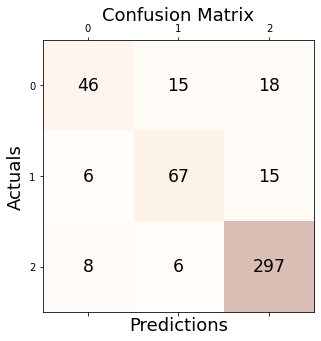

In [ ]:
print(classification_report(Y_test, pred, zero_division=0))

conf_matrix = confusion_matrix(Y_test, pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Test set


In [ ]:
#Read test data
new_data = pd.read_csv('data2tal_testupload.csv')
new_y = pd.read_csv('check_upload_kaggle.csv')

In [ ]:
#Labels test
new_y['target'].value_counts()

2    66
0    61
1    61
Name: target, dtype: int64

In [ ]:
#Convert bool variables to numeric

new_data["forecast_category_at_time_of_weekstart_1_Commit"] = new_data['forecast_category_at_time_of_weekstart_1_Commit'].astype(float)
new_data["forecast_category_at_time_of_weekstart_3_Best_Case"] = new_data["forecast_category_at_time_of_weekstart_3_Best_Case"].astype(float)
new_data["forecast_category_at_time_of_weekstart_4_Pipeline"] = new_data["forecast_category_at_time_of_weekstart_4_Pipeline"].astype(float)

In [ ]:
#Merging date and id into one single identifier

new_data['opportunity_id'] = new_data['opportunity_id'].astype(str) + '_' + new_data['current_date_day'].astype(str) + '_' + new_data['current_date_month'].astype(str) +'_' + new_data['current_date_year'].astype(str)

new_data.drop(['current_date_day'], axis = 1, inplace = True)
new_data.drop(['current_date_month'], axis = 1, inplace = True)
new_data.drop(['current_date_year'], axis = 1, inplace = True)

In [ ]:
new_data

,opportunity_id,TOPICS__mean_calls_Integration__from_opp_creation,TOPICS__min_calls_Library__last_28_days,QUESTIONS__std_num_of_questions_in_calls_by_customer__last_7_days,TOPICS__min_calls_Collaboration__from_current_stage_start,TOPICS__std_calls_Integrations__last_7_days,TOPICS__min_calls_Evaluation_Process__from_current_stage_start,TOPICS__total_calls_3_Pillars__last_28_days,TOPICS__mean_non_zero_calls_Business_Overview__from_current_stage_start,TOPICS__total_calls_Wrap-Up__from_opp_creation,...,opportunity_amount_at_time_of_weekstart,forecast_category_at_time_of_weekstart_1_Commit,forecast_category_at_time_of_weekstart_3_Best_Case,forecast_category_at_time_of_weekstart_4_Pipeline,fc_transition,opportunity_stage_at_time_of_weekstart_max,opportunity_stage_at_time_of_weekstart_min,stage_transition,current_quarter,timetoclose
0,1.74607e+16_23_4_2021,NaN,NaN,2.500000,0.03,225.856861,0.03,15234.592,NaN,NaN,...,45000.0,1.0,1.0,0.0,1.0,16,16,0.0,2,38
1,1.74607e+16_30_4_2021,NaN,NaN,0.000000,0.03,714.082357,0.03,NaN,NaN,NaN,...,45000.0,1.0,0.0,0.0,0.0,16,16,0.0,2,31
2,1.74607e+16_7_5_2021,NaN,0.03,0.000000,0.03,831.110775,0.03,40633.127,NaN,NaN,...,45000.0,1.0,0.0,0.0,0.0,23,16,7.0,2,24
3,1.74607e+16_14_5_2021,NaN,0.03,8.988882,0.03,683.522063,0.03,120800.897,NaN,NaN,...,30000.0,1.0,1.0,0.0,NaN,32,23,9.0,2,17
4,1.74607e+16_21_5_2021,NaN,0.03,11.394736,NaN,722.579496,NaN,217478.271,NaN,NaN,...,30000.0,1.0,0.0,0.0,0.0,32,32,0.0,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,8.90258e+18_19_5_2021,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,9200.0,1.0,0.0,0.0,0.0,16,16,0.0,2,42
184,8.90258e+18_26_5_2021,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,9200.0,1.0,0.0,0.0,0.0,16,16,0.0,2,35
185,8.90258e+18_2_6_2021,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,9200.0,1.0,0.0,0.0,0.0,16,16,0.0,2,20
186,8.90258e+18_9_6_2021,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,9200.0,1.0,0.0,0.0,0.0,16,16,0.0,2,13


In [ ]:
new_X = new_data.drop(['opportunity_id'], axis=1)[X_train.columns]  #Obtain same variables used for training the model
new_y = new_y['target']

In [ ]:
#Preprocessing test data 
new_X = impute_nan(new_X)  #Impute Nan

#Detect outliers and impute those values
for column in new_X.columns:
  new_X[column] = impute_outliers(new_X[column])

In [ ]:
new_X

,TOPICS__min_calls_Library__last_28_days,TOPICS__total_calls_3_Pillars__last_28_days,RESPONSE_TIME__total_email_customer_response_time__last_14_days,TOPICS__total_calls_Next_Steps__last_14_days,QUESTIONS__std_num_of_questions_in_calls_by_company__from_opp_creation,TOPICS__non_zero_calls_Alerts__from_initial_high_interaction_day,TOPICS__median_calls_Pricing__last_14_days,TOPICS__std_calls_Discovery__from_opp_creation,COMMUNICATION_ACTIVITY__total_emails__last_7_days,TOPICS__total_calls_Integrations__last_21_days,...,TOPICS__total_calls_Evaluation_Process__last_21_days,TOPICS__total_calls_Discovery__last_21_days,CRM__total_num_of_amount_update_crm_events__last_14_days,TOPICS__mean_calls_Differentiation__last_28_days,CRM__total_num_of_close_date_update_crm_events__from_opp_creation,TOPICS__mean_calls_Next_Steps__last_14_days,sort_order_at_time_of_weekstart,opportunity_stage_at_time_of_weekstart_max,stage_transition,timetoclose
0,43.311471,52892.855987,73.259167,32250.766696,15.278662,85.000000,858.444737,630.628581,17.000000,40310.760099,...,40464.02346,42776.602797,1.0,1032.062589,4.0,880.147345,5.0,16.0,0.000000,38.0
1,43.311471,52892.855987,86.051944,19180.859000,14.583942,97.000000,858.444737,659.093729,17.000000,19180.859000,...,19180.85900,19180.859000,0.0,1032.062589,4.0,880.147345,5.0,16.0,0.000000,31.0
2,0.030000,40633.127000,78.141389,36799.497000,15.520631,112.000000,858.444737,710.106419,17.000000,40633.127000,...,40633.12700,40633.127000,0.0,991.051878,4.0,880.147345,5.0,23.0,7.000000,24.0
3,0.030000,52892.855987,55.319444,32250.766696,13.710661,56.946154,858.444737,706.357205,8.494681,40310.760099,...,40464.02346,42776.602797,1.0,1088.296369,4.0,880.147345,6.0,32.0,9.000000,17.0
4,0.030000,52892.855987,74.281389,32250.766696,12.749118,56.946154,858.444737,720.274340,8.494681,40310.760099,...,40464.02346,42776.602797,1.0,1032.062589,4.0,880.147345,14.0,32.0,0.000000,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,43.311471,52892.855987,22.303889,32250.766696,0.000000,15.000000,858.444737,643.072511,8.000000,40310.760099,...,40464.02346,42776.602797,0.0,1032.062589,7.0,880.147345,5.0,16.0,0.000000,42.0
184,43.311471,52892.855987,22.303889,32250.766696,0.000000,15.000000,858.444737,643.072511,0.000000,40310.760099,...,40464.02346,42776.602797,0.0,1032.062589,8.0,880.147345,5.0,16.0,0.000000,35.0
185,43.311471,52892.855987,0.000000,32250.766696,0.000000,15.000000,858.444737,643.072511,0.000000,40310.760099,...,40464.02346,42776.602797,0.0,1032.062589,8.0,880.147345,5.0,16.0,0.000000,20.0
186,43.311471,52892.855987,0.000000,32250.766696,0.000000,15.000000,858.444737,643.072511,0.000000,40310.760099,...,40464.02346,42776.602797,0.0,1032.062589,8.0,880.147345,5.0,16.0,0.000000,13.0


In [ ]:
print(new_X.shape)
print(new_y.shape)

(188, 312)
(188,)


In [ ]:
#Standarize test set 

X_norm = pd.DataFrame(scaler.transform(new_X), columns=new_X.columns)

In [ ]:
test_labels = clf.predict(X_norm)

In [ ]:
test_labels

array([0, 0, 0, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 2, 0, 2, 2, 2, 0, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 1,
       1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 1,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 0,
       1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 1, 1, 2, 2, 2, 2, 2])

              precision    recall  f1-score   support

           0       0.33      0.23      0.27        61
           1       0.39      0.20      0.26        61
           2       0.34      0.59      0.43        66

    accuracy                           0.35       188
   macro avg       0.35      0.34      0.32       188
weighted avg       0.35      0.35      0.32       188



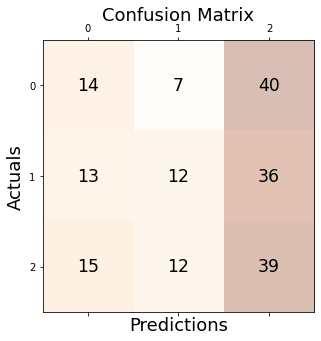

In [ ]:
print(classification_report(new_y, test_labels))

conf_matrix = confusion_matrix(new_y, test_labels)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Csv file and kaggle submisison

In [ ]:
new_y.target = test_labels

In [ ]:
new_y.to_csv(r"prediction_s1083508.csv", index = False)